In [1]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
from tqdm import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
audio_df = pd.read_csv("audio_dataset.csv")
audio_df.head()

,actor,gender,emotion,path
0,1,male,neutral,data/Actor_01/03-01-01-01-01-01-01.wav
1,1,male,neutral,data/Actor_01/03-01-01-01-01-02-01.wav
2,1,male,neutral,data/Actor_01/03-01-01-01-02-01-01.wav
3,1,male,neutral,data/Actor_01/03-01-01-01-02-02-01.wav
4,1,male,calm,data/Actor_01/03-01-02-01-01-01-01.wav


# Data Augmentation

In [3]:
# Noise
# rate of noise = 0.035, Noise increases as rate increases
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Stretch
# rate of stretching audio = 0.8, Audio is streched more as rate decreases
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

# Shift
# shifts the initial part of audio at the end in left to right direction
def shift(data):
    shift_range = int(np.random.uniform(low = -5, high = 5)*1000)
    return np.roll(data, shift_range)

# Pitch
# pitch_factor = 0.7 --> adjusts the pitch of the audio
# negative values for greater pitch, positive(higher) values for lower pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


Normal Audio

In [4]:
path = np.array(audio_df['path'])[65]
data, sample_rate = librosa.load(path)

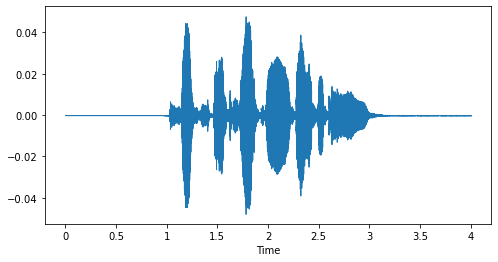

In [5]:
plt.figure(figsize=(8,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

Audio with noise

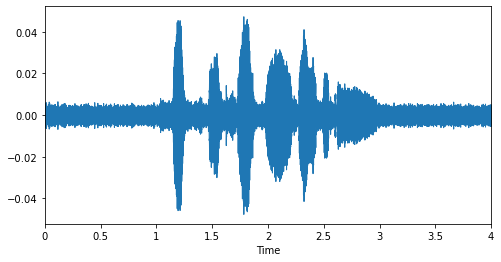

In [6]:
x = noise(data)
plt.figure(figsize=(8,4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with stretch 

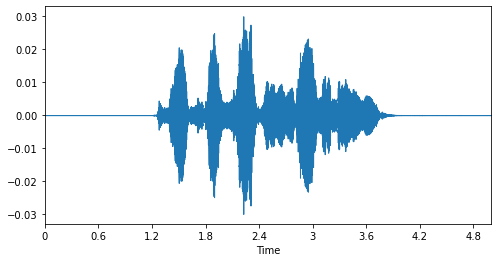

In [7]:
x = stretch(data)
plt.figure(figsize=(8, 4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with shift

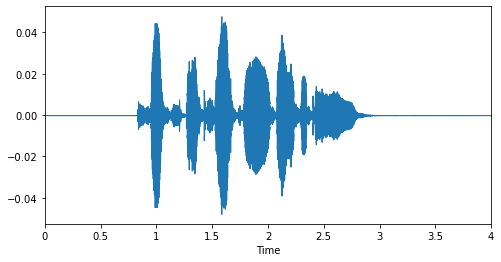

In [8]:
x = shift(data)
plt.figure(figsize=(8,4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with pitch

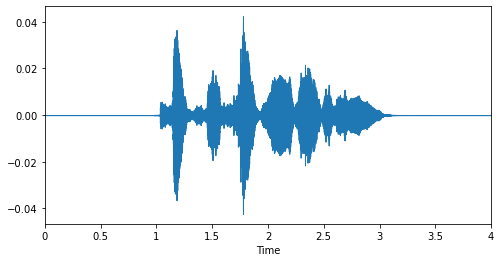

In [9]:
x = pitch(data, sample_rate)
plt.figure(figsize=(8, 4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

# Feature Extraction

In [10]:
def feature_extraction(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

# duration = 2.5, 
# offset = 0.6 --> considers audio of 2.5 duration starting from 0.6 sec
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # normal data
    res1 = feature_extraction(data)
    result = np.array(res1)
    
    #data with noise
    noise_data = noise(data)
    res2 = feature_extraction(noise_data)
    result = np.vstack((result, res2))
    
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feature_extraction(data_stretch_pitch)
    result = np.vstack((result, res3))
    
    return result

In [11]:
X, Y = [], []
for path,gender,emotion in zip(audio_df['path'], audio_df['gender'],audio_df['emotion']):
    feature = get_features(path)
    for element in feature:
        X.append(element)
        Y.append(gender+"_"+emotion)

In [12]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [13]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-655.344543,86.649864,-12.361261,28.343275,-0.276913,9.111378,-10.830962,-0.023427,-17.030333,-3.272646,...,-5.887830,4.827703,-7.893807,3.420066,-1.663579,-3.320956,-4.437192,-0.790467,-2.032093,male_neutral
1,-411.594958,24.833259,8.930745,8.555698,5.613364,-0.045326,-2.931558,-6.162607,-7.933866,-5.501870,...,-1.682008,-1.195739,-1.113047,0.145768,0.106512,-3.527218,-2.978324,-0.437862,-2.180341,male_neutral
2,-724.307190,84.484085,-14.169809,31.049458,-3.062177,9.604401,-14.447046,-0.219916,-20.591162,2.434901,...,-4.020089,3.011852,-8.109156,3.908099,-5.972445,-3.686382,-5.658265,2.423278,-4.886253,male_neutral
3,-645.409851,87.810638,-17.773392,33.468960,-0.936478,8.191232,-9.919904,-3.311972,-18.590483,-2.199426,...,-6.660093,3.893641,-8.572474,2.928271,-3.344517,-3.604978,-4.101902,-1.308776,-0.581940,male_neutral
4,-424.680577,26.363800,9.045823,9.987644,5.088241,-0.288137,-2.486889,-6.662663,-8.610371,-5.107760,...,-2.503558,-2.470244,-1.610390,-0.685399,-1.072203,-3.549439,-3.315849,-1.009178,-2.569455,male_neutral
